### Libraries

In [ ]:
# Import standard libraries
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import statsmodels.api as sm

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import (
    confusion_matrix, 
    roc_curve, 
    classification_report,
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score,
    roc_auc_score
)
from sklearn.multiclass import OneVsRestClassifier
from sklearn.impute import SimpleImputer

#import helper functions
from helper import *
# Display settings for better visuals in the notebook
%matplotlib inline
sns.set(style="whitegrid")

print("Libraries imported successfully.")


Helper functions defined successfully.
Libraries imported successfully.


### Load and Process data

In [3]:
# Load and merge data
ML_df = load_and_merge_data('../Export/Voorspellers.csv', '../Export/uitkomstmaat.csv')

# Display the first few rows to verify the new derived columns
ML_df.columns


Index(['Participant Id', 'pat_sexe', 'T0_age', 'T0_BMI', 'T0_VVMI_per',
       'Education', 'household', 'Tumorlocation_strat', 'T0_Tumorsize',
       'T0_ASA', 'T0_diseaseburden_cat', 'T0_selfcare',
       'T0_Locusofcontrol_cat', 'T0_socialsupport_cat', 'T0_coping_cat',
       'OK_pretreatment', 'Time_pretreat_OK', 'OK_Technique',
       'OK_Duration_min', 'Complications', 'Complications_CCI',
       'Complications_severe', 'AMEXO_8_day1', 'AMEXO_9_day2',
       'Length_of_stay', 'OK_posttreatment', 'Time_OK_posttreat',
       'T0_sondevoeding', 'T0_30SCST', 'T0_pain', 'T0_fatigue', 'T0_HKK_per',
       'T0_protein_perc', 'T0_kcal_perc', 'T0_eetlust', 'T0_CT_SMI',
       'T0_CT_SMRA', 'T0_ASM_low', 't0_gses_totaal_score',
       'T0_participation_ability', 'T0_participation_satisfaction',
       't0_EQ_5D_5L_beschrijvend-systeem_score', 'T0_anxiety_cat',
       'T0_depression_cat', 'T0', 'T2', 'T3', 'T4', 'T5', 'T6', 'T2_relative',
       'T3_relative', 'T4_relative', 'T5_relative', 

In [4]:
# Start encoding process on ML_df
# 1. One-Hot Encoding for Nominal Categorical Variables
# Tumorlocation_strat (Tumor location), T0_coping_cat (Coping style)
ML_df = pd.get_dummies(ML_df, columns=['Tumorlocation_strat', 'T0_coping_cat'], dummy_na=False)

# 2. Binary Transformation for T0_selfcare
# Combining 0 and 1 as "Disagree" (0), and 2 and 3 as "Agree" (1)
ML_df['T0_selfcare'] = ML_df['T0_selfcare'].replace({0: 0, 1: 0, 2: 1, 3: 1})

# 3. Binary Transformation for T0_anxiety_cat
# Combining 1 (sometimes) and 2 (often) as "Sometimes/Often" (1), keeping 0 (never) as is
ML_df['T0_anxiety_cat'] = ML_df['T0_anxiety_cat'].replace({1: 1, 2: 1})

# 4. Binary Transformation for OK_posttreatment
# Combining 1 (chemotherapy), 2 (radiation), and 3 (chemo radiation) as "Treatment" (1), keeping 0 (No treatment) as is
ML_df['OK_posttreatment'] = ML_df['OK_posttreatment'].replace({1: 1, 2: 1, 3: 1})

# 5. Handling T0_Tumorsize
# Setting 8 (unknown) to NaN for missingness handling later
ML_df['T0_Tumorsize'] = ML_df['T0_Tumorsize'].replace(8, np.nan)

# 6. Simplified Encoding for T0_Locusofcontrol_cat and T0_socialsupport_cat
# T0_Locusofcontrol_cat: Combining 'Low' (0) and 'Medium' (1) into 'Low/Medium' (0), keeping 'High' (2) as 1
ML_df['T0_Locusofcontrol_cat'] = ML_df['T0_Locusofcontrol_cat'].replace({0: 0, 1: 0, 2:1})

# T0_socialsupport_cat: Combining 'No Support' (0) and 'Some Support' (1) into 'Low/Some Support' (0), keeping 'A Lot of Support' (2) as is
ML_df['T0_socialsupport_cat'] = ML_df['T0_socialsupport_cat'].replace({0: 0, 1: 0, 2:1})

# Display only the changed columns for verification
changed_columns = [
    'T0_selfcare', 'T0_anxiety_cat', 'OK_posttreatment', 'T0_Tumorsize',
    'T0_Locusofcontrol_cat', 'T0_socialsupport_cat'
] + [col for col in ML_df.columns if 'Tumorlocation_strat' in col or 'T0_coping_cat' in col]


In [5]:
# Assuming ML_df is the DataFrame to be processed
ML_df = impute_missing_values(ML_df)


# Replace missing values in 'Complication_CCI' with 0
ML_df['Complications_CCI'].fillna(0, inplace=True)


# Display the first few rows to verify imputation
ML_df.head()

# Check for remaining missing values in ML_df after encoding and initial imputation steps
remaining_missing_values = ML_df.isnull().sum()

# Filter and display columns with missing values only
remaining_missing_values = remaining_missing_values[remaining_missing_values > 0]
remaining_missing_values

Missing categorical columns not found in df: {'AMEXO_10_day3', 'T0_protein_cat', 'T0_coping_cat', 'T0_kcal_cat'}


T2             36
T3             33
T4             48
T5             57
T6             86
T2_relative    37
T3_relative    34
T4_relative    50
T5_relative    58
T6_relative    88
dtype: int64

### Modelling Scenarios

#### T6 - all variabels

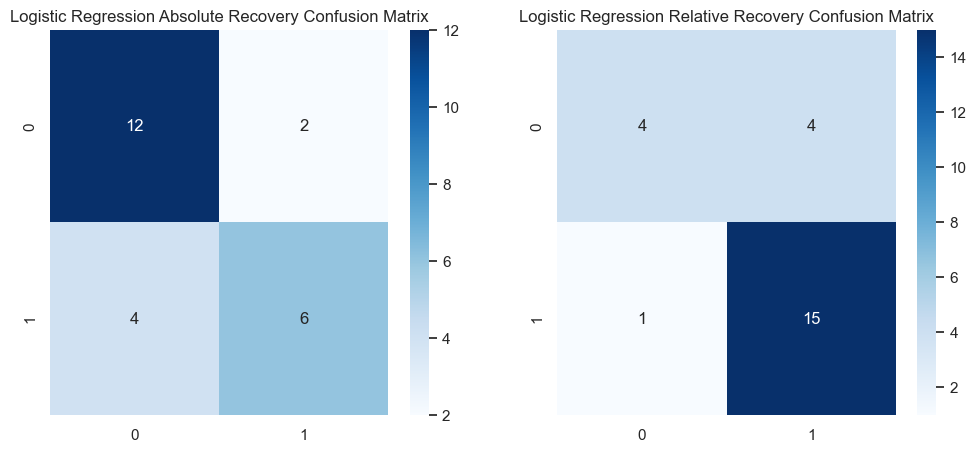

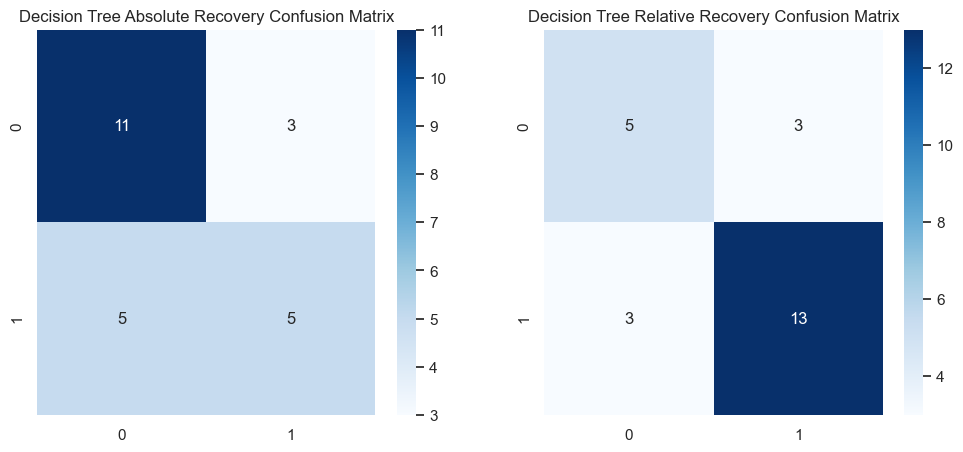

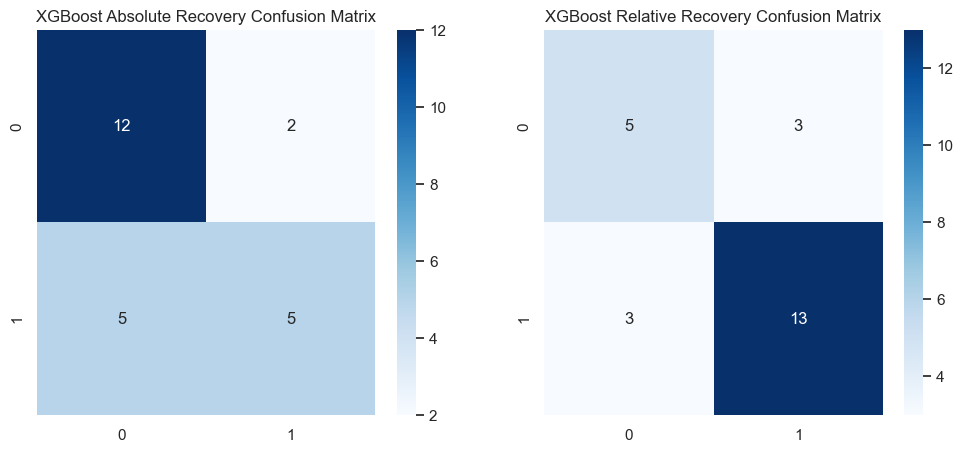

,Model,Accuracy,Precision,Recall,F1 Score,ROC AUC
0,Abs outcome Logistic Regression,0.750000,0.750000,0.728571,0.833333,0.728571
1,Relative outcome Logistic Regression,0.791667,0.794737,0.718750,0.836264,0.718750
2,Abs outcome Decision Tree,0.666667,0.656250,0.642857,0.744444,0.642857
3,Relative outcome Decision Tree,0.750000,0.718750,0.718750,0.818750,0.718750
4,Abs outcome XGBoost,0.708333,0.710084,0.678571,0.781214,0.678571
5,Relative outcome XGBoost,0.750000,0.718750,0.718750,0.818750,0.718750
6,Null Model Abs outcome,0.583333,0.291667,0.500000,0.368421,0.500000
7,Null Model Relative outcome,0.666667,0.333333,0.500000,0.400000,0.500000


In [ ]:
plot_options = {
    "confusion_matrix": True,
    "roc_curve": False,
    "feature_importance": False,
    "decision_tree": True  }

results = train_models_with_outcomes(df=ML_df, outcome_mode='double', outcome_type="relative", time_horizon="T6", traditional_vars=False, plot=plot_options)
results

#### T6 - statistics only

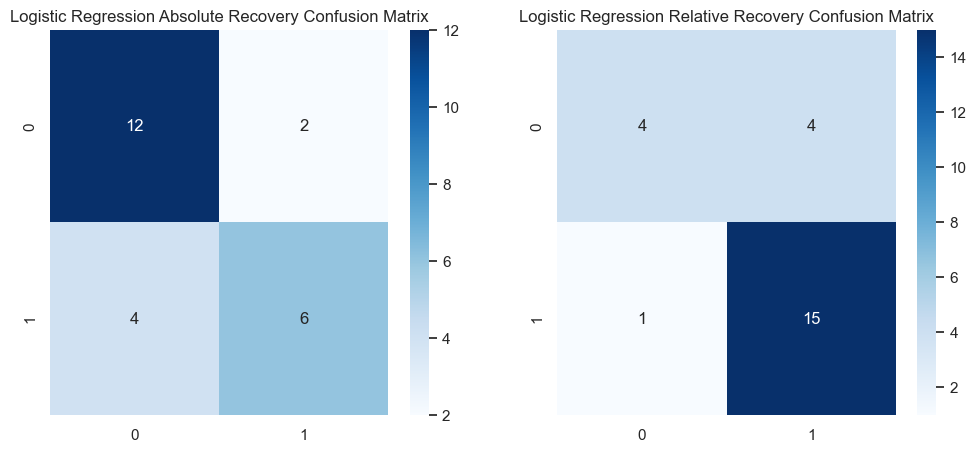

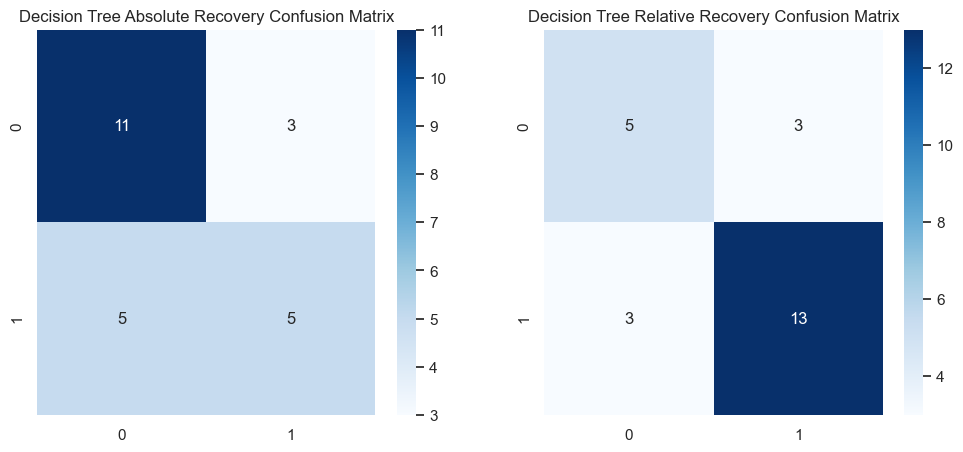

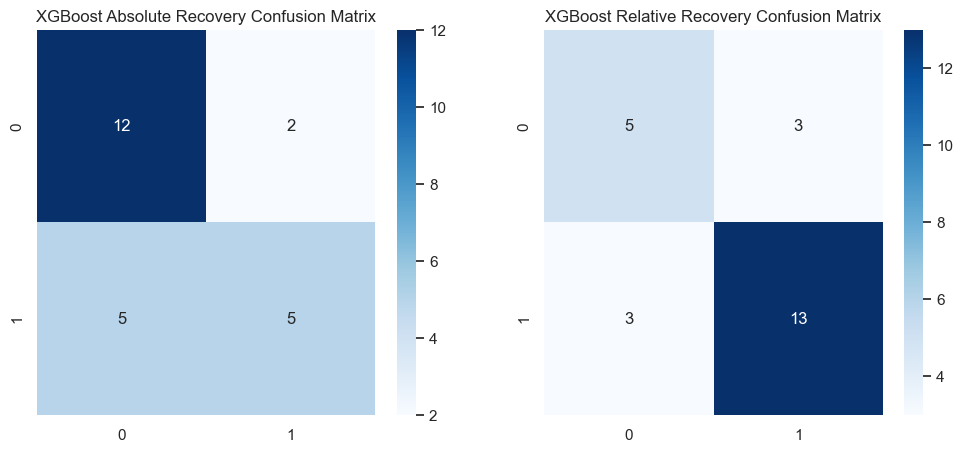

,Model,Accuracy,Precision,Recall,F1 Score,ROC AUC
0,Abs outcome Logistic Regression,0.750000,0.750000,0.728571,0.733333,0.728571
1,Relative outcome Logistic Regression,0.791667,0.794737,0.718750,0.736264,0.718750
2,Abs outcome Decision Tree,0.666667,0.656250,0.642857,0.644444,0.642857
3,Relative outcome Decision Tree,0.750000,0.718750,0.718750,0.718750,0.718750
4,Abs outcome XGBoost,0.708333,0.710084,0.678571,0.681214,0.678571
5,Relative outcome XGBoost,0.750000,0.718750,0.718750,0.718750,0.718750
6,Null Model Abs outcome,0.583333,0.291667,0.500000,0.368421,0.500000
7,Null Model Relative outcome,0.666667,0.333333,0.500000,0.400000,0.500000


In [11]:
plot_options = {
    "confusion_matrix": True,
    "roc_curve": False,
    "feature_importance": False,
    "decision_tree": False  }

results = train_models_with_outcomes(df=ML_df, outcome_mode='double', outcome_type="relative", time_horizon="T6", traditional_vars=True, plot=plot_options)
results

#### T5

In [ ]:
plot_options = {
    "confusion_matrix": False,
    "roc_curve": False,
    "feature_importance": False,
    "decision_tree": False  }
results = train_models_with_outcomes(df=ML_df, outcome_mode='double', outcome_type="relative", time_horizon="T5", traditional_vars=True, plot=plot_options)
results

,Model,Accuracy,Precision,Recall,F1 Score,ROC AUC
0,Abs outcome Logistic Regression,0.71875,0.727451,0.741667,0.716256,0.741667
1,Relative outcome Logistic Regression,0.75000,0.763636,0.730159,0.733333,0.730159
2,Abs outcome Decision Tree,0.81250,0.801587,0.816667,0.805668,0.816667
3,Relative outcome Decision Tree,0.75000,0.761905,0.761905,0.750000,0.761905
4,Abs outcome XGBoost,0.71875,0.785714,0.775000,0.718475,0.775000
5,Relative outcome XGBoost,0.68750,0.690909,0.666667,0.666667,0.666667
6,Null Model Abs outcome,0.62500,0.312500,0.500000,0.384615,0.500000
7,Null Model Relative outcome,0.56250,0.281250,0.500000,0.360000,0.500000
